# [Neural Machine Translation with Attention](https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention)

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

![](spanish-english.png)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import io
import time
import unicodedata
import re

# !pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Download and prepare the dataset

We'll use a language dataset provided by [http://www.manythings.org/anki/](http://www.manythings.org/anki/). This dataset contains language translation pairs in the format:

`May I borrow this book? ¿Puedo tomar prestado este libro?`

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
1. Clean the sentences by removing special characters.
1. Create a word index and reverse word index (dictionaries mapping from word &#8594; id and id &#8594; word).
1. Pad each sentence to a maximum length.

In [2]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    fname='spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True,
)

# path_to_file = os.path.dirname(path_to_zip) + '/spa-eng/spa.txt'
path_to_file = 'spa-eng/spa.txt'
os.path.exists(path_to_file)

True

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r'([?.!,¿])', r' \1 ', w)
    w = re.sub(r'[" "]+', ' ', w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
en_sentence = u'May I borrow this book?'
sp_sentence = u'¿Puedo tomar prestado este libro?'
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [6]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer

In [9]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [10]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

max_length_targ, max_length_inp

(11, 16)

In [11]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [12]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print(f'{t} ----> {lang.index_word[t]}')

In [13]:
print('Input Language; index to word mapping')
convert(inp_lang, input_tensor_train[0])
print()
print('Target Language; index to word mapping')
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
1613 ----> agarra
1850 ----> fuertemente
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
699 ----> hang
42 ----> on
3 ----> .
2 ----> <end>


### Create a `tf.data` dataset

In [14]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

![](attention_mechanism.jpg)

The input is put through an encoder model which gives us the encoder output of shape `(batch_size, max_length, hidden_size)` and the encoder hidden state of shape `(batch_size, hidden_size)`.

Here are the equations that are implemented:

![](attention_equation_0.jpg)

![](attention_equation_1.jpg)

This tutorial uses [Bahdaunau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

- FC = Fully connected (dense) layer
- EO = Encoder output
- H = hidden state
- X = input to the decoder

And the pseudo-code:

- `score = FC(tanh(FC(EO) + FC(H))`
- `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is `(batch_size, max_length, hidden_size)`. `max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
- `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
- `embedding output` = The input to the decoder X is passed through an embedding layer.
- `merged vector = concat(embedding output, context vector)`
- This merged vector is then given to the GRU.

The shapes of all the vectors at each step have been specified in the comments in the code:

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform',
        )
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print(f'Encoder output shape: (batch_size, sequence_length, units) {sample_output.shape}')
print(f'Encoder hidden state shape: (batch_size, units) {sample_hidden.shape}')

Encoder output shape: (batch_size, sequence_length, units) (64, 16, 1024)
Encoder hidden state shape: (batch_size, units) (64, 1024)


In [18]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        # hidden.shape is (batch_size, hidden_size)
        # hidden_with_time_axis.shape is (batch_size, 1, hidden_size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)
        
        # score.shape is (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        
        # attention_weights.shape is (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vecctor.shape after sum is (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print(f'Attention result shape: (batch_size, units) {attention_result.shape}')
print(f'Attention weights shape: (batch_size, sequence_length, 1) {attention_weights.shape}')

Attention result shape: (batch_size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform',
        )
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # enc_output.shape is (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # x.shape after passing through embedding is (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x.shape after concatenation is (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output.shape is (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output.shape is (batch_size, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)

print(f'Decoder output shape: (batch_size, vocab_size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab_size) (64, 5107)


## Define the optimizer and the loss function

In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, 
    reduction='none',
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    _loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=_loss.dtype)
    _loss *= mask
    
    return tf.reduce_mean(_loss)

## Checkpoints (Object-based saving)

In [23]:
checkpoint_dir = 'en_sp_nmt_checkpoints'
checkpoint_prefix = f'{checkpoint_dir}/ckpt'
checkpoint = tf.train.Checkpoint(
    optimizer=optimizer,
    encoder=encoder,
    decoder=decoder,
)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
1. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
1. The decoder returns the *predictions* and the *decoder hidden state*.
1. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
1. Use *teacher forcing* to decide the next input to the decoder.
1. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
1. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(targ[:, t], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        variables = encoder.trainable_variables + decoder.trainable_variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        return batch_loss

In [25]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
            
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start} sec\n')

Epoch 1 Batch 0 Loss 4.4878
Epoch 1 Batch 100 Loss 2.2364
Epoch 1 Batch 200 Loss 1.9521
Epoch 1 Batch 300 Loss 1.6653
Epoch 1 Loss 2.0039
Time taken for 1 epoch 94.88148379325867 sec

Epoch 2 Batch 0 Loss 1.6559
Epoch 2 Batch 100 Loss 1.5877
Epoch 2 Batch 200 Loss 1.4534
Epoch 2 Batch 300 Loss 1.2217
Epoch 2 Loss 1.3836
Time taken for 1 epoch 87.58755493164062 sec

Epoch 3 Batch 0 Loss 1.3442
Epoch 3 Batch 100 Loss 1.1791
Epoch 3 Batch 200 Loss 1.0533
Epoch 3 Batch 300 Loss 0.9056
Epoch 3 Loss 1.0440
Time taken for 1 epoch 82.72089838981628 sec

Epoch 4 Batch 0 Loss 0.9969
Epoch 4 Batch 100 Loss 0.8615
Epoch 4 Batch 200 Loss 0.7778
Epoch 4 Batch 300 Loss 0.6431
Epoch 4 Loss 0.7502
Time taken for 1 epoch 86.3126630783081 sec

Epoch 5 Batch 0 Loss 0.7124
Epoch 5 Batch 100 Loss 0.6046
Epoch 5 Batch 200 Loss 0.5149
Epoch 5 Batch 300 Loss 0.4266
Epoch 5 Loss 0.5054
Time taken for 1 epoch 79.40640759468079 sec

Epoch 6 Batch 0 Loss 0.5249
Epoch 6 Batch 100 Loss 0.4035
Epoch 6 Batch 200 Loss 

## Translate

- The evaluate function is similar to the training loop, excep we don't use *teacher forcing* here. The input to the decoder at each timestep is its previous predictions along with the hidden state and the encoder output.
- Stop predicting when the model predicts the *end token*.
- And store the *attention weights* for every timestep.

In [35]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        sequences=[inputs],
        maxlen=max_length_inp,
        padding='post',
    )
    
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result += targ_lang.index_word[predicted_id] + ' '
        
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention_plot

In [36]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    plt.show()

In [37]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    
    print(f'Input: {sentence}')
    print(f'Predicted translation: {result}')
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the lastest checkpoint and test

In [29]:
# restoring the lastest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it's very cold here . <end> 


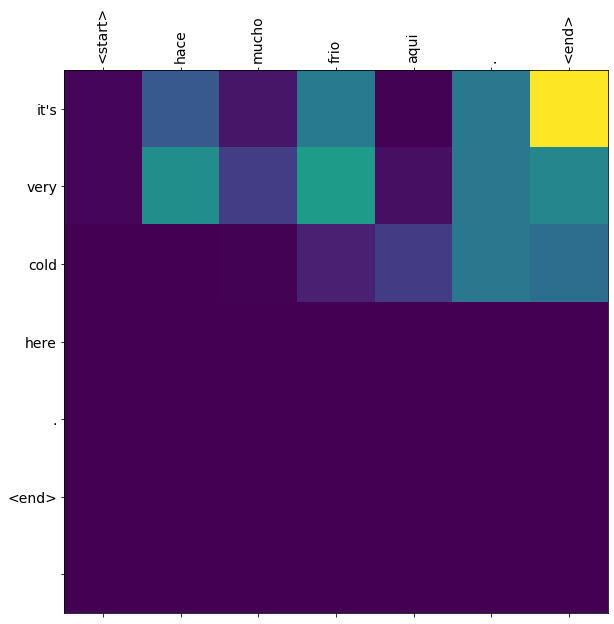

In [38]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


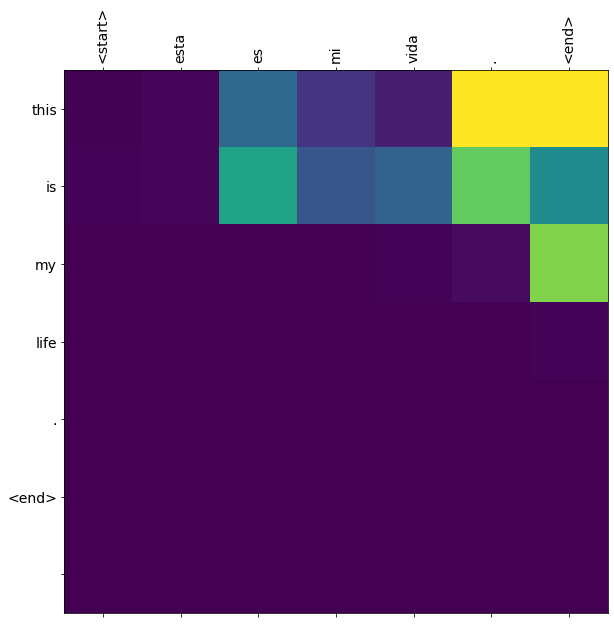

In [39]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


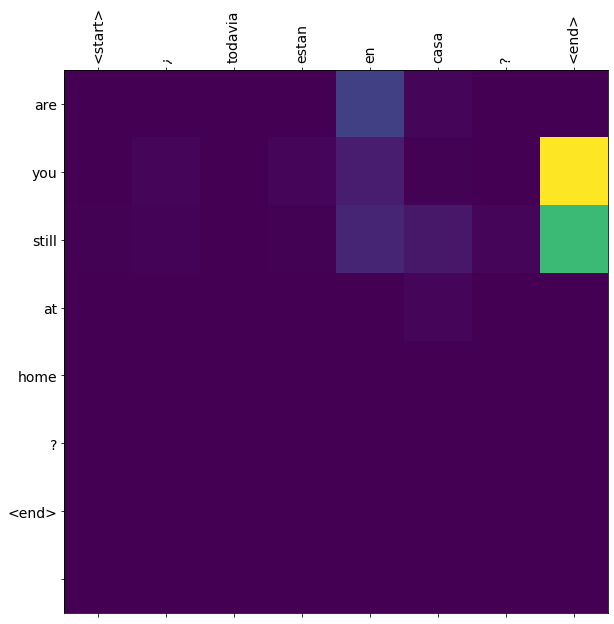

In [40]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


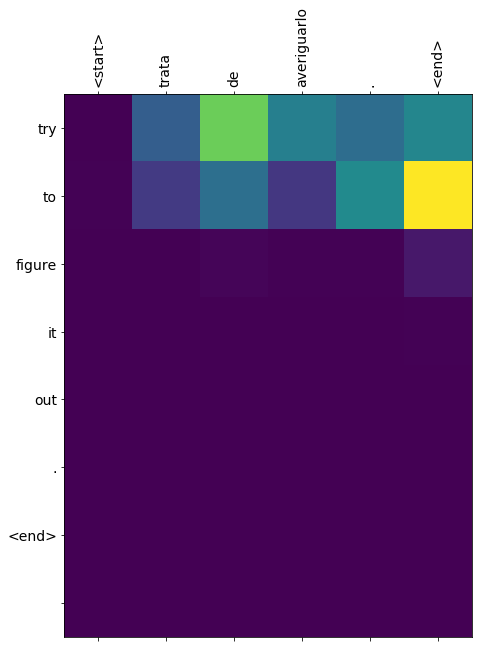

In [41]:
# wrong translation
translate(u'trata de averiguarlo.')

## Next steps

- [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
- Experiment with training on a larger dataset, or using more epochs.